In [38]:
import tensorflow as tf
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
from keras.layers import LSTM, Dense, Dropout, Masking
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [39]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [40]:
# Download bitcoin price data
data = yf.download('BTC-USD', '2014-06-20', '2024-06-20')

[*********************100%%**********************]  1 of 1 completed


In [41]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2024-06-15,66006.742188,66402.187500,65871.773438,66191.000000,66191.000000,14121265576
2024-06-16,66189.359375,66894.843750,66018.250000,66639.046875,66639.046875,13281140541
2024-06-17,66636.515625,67188.320312,65094.964844,66490.296875,66490.296875,30006354476


In [42]:
# Convert the downloaded data into a pandas DataFrame
data = pd.DataFrame(data)
# Reset the index of the DataFrame (making the date column an actual column)
data.reset_index(inplace=True)
# Drop unnecessary columns: 'Date', 'Open', 'High', 'Low', 'Adj Close', and 'Volume'
data.drop(columns=['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)


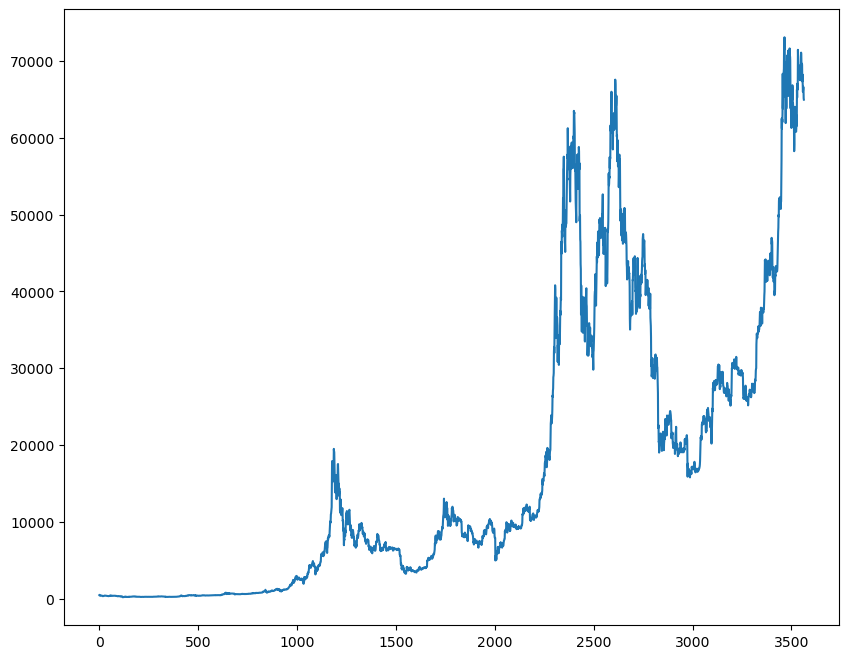

In [43]:
# Visualize the data
plt.figure(figsize=(10, 8))
plt.plot(data)
# Display the figure for a few seconds (e.g., 3 seconds)
plt.show(block=False)
plt.pause(5)  # Pause for 5 seconds
plt.close()  # Close the figure

In [44]:
# Split the data into training and testing data
train_data = data[:-200]
test_data = data[-200:]

In [45]:
train_data.shape

(3364, 1)

In [46]:
test_data.shape

(200, 1)

In [47]:
# Scale training data into the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scale = scaler.fit_transform(train_data)

In [48]:
# Number of previous days to use for prediction
base_days = 100

In [49]:
# Create input sequences (x) and corresponding target values (y)
x = []
y = []

for i in range(base_days, train_data_scale.shape[0]):
    x.append(train_data_scale[i - base_days:i])
    y.append(train_data_scale[i, 0])

In [50]:
# Convert arrays to numpy arrays
x, y = np.array(x), np.array(y)

In [51]:
# Reshape input data to match LSTM input shape
x = np.reshape(x, (x.shape[0],x.shape[1],1))

In [52]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(x.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100, 64)           16896     
                                                                 
 dropout_8 (Dropout)         (None, 100, 64)           0         
                                                                 
 lstm_9 (LSTM)               (None, 100, 64)           33024     
                                                                 
 dropout_9 (Dropout)         (None, 100, 64)           0         
                                                                 
 lstm_10 (LSTM)              (None, 100, 64)           33024     
                                                                 
 dropout_10 (Dropout)        (None, 100, 64)           0         
                                                                 
 lstm_11 (LSTM)              (None, 64)               

In [54]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [55]:
# Add callbacks for monitoring loss, saving the best model, and early stopping
callbacks = [
    ModelCheckpoint(filepath='../model/best_model.keras', monitor='val_loss', save_best_only=True, save_weights_only=True),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

In [56]:
# Train the model
model.fit(x, y, epochs=60, verbose=1, validation_split=0.1, callbacks=callbacks)

Epoch 1/60
92/92 [==============================] - 134s 1s/step - loss: 0.0246 - mae: 0.0980 - val_loss: 0.0082 - val_mae: 0.0847
Epoch 2/60
92/92 [==============================] - 129s 1s/step - loss: 0.0067 - mae: 0.0493 - val_loss: 0.0020 - val_mae: 0.0350
Epoch 3/60
92/92 [==============================] - 129s 1s/step - loss: 0.0057 - mae: 0.0433 - val_loss: 0.0014 - val_mae: 0.0276
Epoch 4/60
92/92 [==============================] - 125s 1s/step - loss: 0.0049 - mae: 0.0396 - val_loss: 0.0035 - val_mae: 0.0518
Epoch 5/60
92/92 [==============================] - 122s 1s/step - loss: 0.0050 - mae: 0.0413 - val_loss: 9.5270e-04 - val_mae: 0.0256
Epoch 6/60
92/92 [==============================] - 122s 1s/step - loss: 0.0050 - mae: 0.0402 - val_loss: 0.0035 - val_mae: 0.0527
Epoch 7/60
92/92 [==============================] - 129s 1s/step - loss: 0.0047 - mae: 0.0387 - val_loss: 9.9119e-04 - val_mae: 0.0265
Epoch 8/60
92/92 [==============================] - 118s 1s/step - loss: 0.

In [84]:
model.save('../model/BitcoinPricePrediction.keras')

In [57]:
test_data = pd.concat((train_data.tail(100), test_data), ignore_index=True)

In [59]:
test_data_scale = scaler.fit_transform(test_data)

In [60]:
# Create input sequences (x) and corresponding target values (y) (i.e. array slicing)
x = []
y = []

for i in range(base_days, test_data_scale.shape[0]):
    x.append(test_data_scale[i - base_days:i])
    y.append(test_data_scale[i, 0])

In [61]:
# Convert arrays to numpy arrays
x, y = np.array(x), np.array(y)

In [62]:
x = np.reshape(x, (x.shape[0],x.shape[1],1))

In [63]:
pred = model.predict(x)

7/7 [==============================] - 1s 118ms/step


In [74]:
pred = scaler.inverse_transform(pred)

In [76]:
pred 

array([[55862.055]], dtype=float32)

In [80]:
#45 days future price prediction 
f = y
F= []
future_days = 45
for i in range(base_days, len(f)+future_days):
    f = f.reshape(-1,1)
    inter = [f[-base_days:,0]]
    inter = np.array(inter)
    inter = np.reshape(inter, (inter.shape[0], inter.shape[1],1))
    pred = model.predict(inter)
    f = np.append(f ,pred)
    F = np.append(F, pred)


1/1 [==============================] - 1s 577ms/step


In [81]:
F = np.array(F)
F = scaler.inverse_transform(F.reshape(-1,1))

In [82]:
F

array([[64247.75188815],
       [63904.4240289 ],
       [63580.41050395],
       [63274.4402576 ],
       [62984.77380011],
       [62709.8201696 ],
       [62448.31116666],
       [62199.27564758],
       [61961.94526634],
       [61735.6145156 ],
       [61519.58645694],
       [61313.16129564],
       [61115.64780589],
       [60926.36904342],
       [60744.70804634],
       [60570.09640997],
       [60402.04856246],
       [60240.15319588],
       [60084.06184103],
       [59933.49743633],
       [59788.22005216],
       [59648.02974717],
       [59512.74943045],
       [59382.21058   ],
       [59256.26466797],
       [59134.74888498],
       [59017.52327207],
       [58904.43358878],
       [58795.32845094],
       [58690.0593307 ],
       [58588.48055651],
       [58490.46073832],
       [58395.84849198],
       [58304.52099638],
       [58216.34971778],
       [58131.21754769],
       [58048.99595237],
       [57969.58210486],
       [57892.86746556],
       [57818.7492075 ],
